# CSTRs

These exercises cover numerical solution of steady state and transient CSTR problems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp

## Example Problem 01

**Note: Compare to Example Problem 03 from Lecture 14, which solves the identical problem in a PFR at steady state.**

Consider the following liquid-phase, irreversible, homogeneous reaction that is occuring in a perfectly-mixed CSTR

$$\textrm{A + B} \longrightarrow \textrm{C}$$

This reaction is first order in A and first order in B. You may assume that the liquid phase has a constant density. Additional data are given below:

$$k = 25.3 \frac{L}{mol \cdot h}$$
$$Q_f = 10 \frac{L}{h}$$
$$F_{Af} = 10 \frac{mol}{h}$$
$$F_{Bf} = 10 \frac{mol}{h}$$

What fractional conversion of species A is achieved in 1.24 L CSTR?

### Analytical Solution to Example Problem 01

We write a balance on A:

$$0 = F_{A,f} - F_A + R_AV$$

We see an intensive production rate, $R_A$, which we define as usual:

$$R_A = \sum_{i = 1}^{N_R} \nu_{i,A} \, r_i$$

And for this single reaction:

$$R_A = -r$$

We know the rate expression:

$$r = kC_AC_B$$

So this gives

$$R_A = -kC_AC_B$$

Which we can substitute into the material balance:

$$0 = F_{A,f} - F_A - kC_AC_BV$$

We have 3 unknowns in that equation: $F_A$, $C_A$, $C_B$. We are given Volume in the problem statement (1.24L).  If we want to solve this by hand, we'll need to express $F_A$, $C_A$, $C_B$ in terms of a single unknown.  I'll choose to work with fractional conversion of A here.  Completing a mole table, we find:

\begin{align}
    F_A &= F_{A,f}(1 - X_A) \\
    F_B &= F_{B,f} - F_{A,f}X_A \\
\end{align}

But:  we see in the problem statement, that for this problem, $F_{A,f} = F_{B,F}$.  So, in this special case:

\begin{align}
    F_A &= F_{A,f}(1 - X_A) \\
    F_B &= F_{A,f}(1 - X_A) \\
\end{align}

Then we define concentrations as usual; for a constant density flow reactor, $Q = Q_f$:

\begin{align}
    C_A &= F_A/Q_f \\
    C_B &= F_A/Q_f \\
\end{align}

Substituting everything into the material balance, we get:

$$0 = F_{A,f} - F_{A,f}(1 - X_A) - kF_{A,f}^2(1-X_A)^2\frac{V}{Q_f^2}$$

I solved this by simplifying, doing some FOIL magic, and using the quadratic formula.  Essentially, I get:

$$0 = X_A^2 + (\alpha - 2)X_A + 1$$

Where $\alpha = -Q_f^2/k/F_{A,f}/V$

If you solve that with the quadratic formula, you'll find two roots at:

$$X_A = 0.573$$

and at

$$X_A = 1.746$$

Mathematically, they are both fine, but physically, we can't have a conversion of more than 100% since it would mean we consume more reactant than we put into the reactor.  So we reject the upper root and conclude that our solution is:

$$X_A = 0.573$$

### Numerical Solution of Example Problem 01

This is a steady state CSTR, so it involves solution of algebric equations. This means that we need to use an algebraic equation solver like `opt.newton()` or `opt.root()` to solve the problem numerically.

Below, we'll create a univariate objective function by expressing all molar flowrates as functions of the fractional conversion of species A, $X_A$.

In [2]:
def P01(XA):
    FAf = 10 #mol/h
    FBf = 10 #mol/h
    Qf  = 10 #L/h
    k   = 25.3 #L/mol/h
    V   = 1.24 #L
    
    FA  = FAf*(1-XA)
    FB  = FBf - FAf*XA
    
    Q   = Qf
    CA  = FA/Q
    CB  = FB/Q
    
    r   = k*CA*CB
    
    RA  = -r
    
    LHS = FAf - FA + RA*V
    return LHS

In [3]:
XA0 = 0.5
sol, info = opt.newton(P01, XA0, full_output = True)
print(info, '\n')
print(f"At steady state, this 1.24L CSTR achieves a conversion of A of {sol:0.3f}.")

      converged: True
           flag: converged
 function_calls: 6
     iterations: 5
           root: 0.5727289521699684 

At steady state, this 1.24L CSTR achieves a conversion of A of 0.573.


## Example Problem 02: What if the CSTR is not at steady state?

Assume a CSTR initially contains a solvent that is equal in density to the typical reactor contents (it just has no reactants or products in it). The feed stream contains species A and B in a concentration of 1.00 $\text{mol/L}$. <ins>Approximately how long will it take to reach steady state?</ins> The volume of this reactor is 1.24 $L$. Additional details are below:

The raction being carried out is:

$$\textrm{A + B} \longrightarrow \textrm{P}$$

This reaction is first order in A and first order in B. You may assume that the liquid phase always has constant density that is exactly the same as the solvent initially inside of the reactor. You may additionally assume that, because of this, the volumetric flowrate into and out of the reactor are always equal.

$$k = 25.3 \ \text{L} \ \text{mol}^{-1} \ \text{h}^{-1}$$

$$Q_f = 10 \ \text{L} \ {h}^{-1}$$


### Solution to Example Problem 02

In this case, the left hand side of the material balance, $\frac{dN_j}{dt}$, no longer equal to zero. The transient CSTR becomes an ODE (initial value problem).

We start by writing a balance on species A:

$$\frac{dN_A}{dt} = F_{Af} - F_A + R_AV$$

We note here that our independent variable is time and our state dependent variable is $N_A$. This means that if we hope to solve this ODE analytically, everything on the right hand side needs to be a function of $(t, N_A)$.  We start making definitions:

Because density and volume in this system are constant, $Q = Q_f$, and we can therefore define the exit molar flowrate of A as:

$$F_A = C_AQ_f$$

We know $Q_f$, but we need to define $C_A$ in terms of our state variables.  This is relatively straightforward for a constant volume reactor:

$$C_A = \frac{N_A}{V}$$

Now we define the intensive production rate of A:

$$R_A = -r$$

And the rate of reaction is given by:

$$r = kC_AC_B$$

This requires a definition of $C_B$:

$$C_B = \frac{N_B}{V}$$

And now we have to make a choice of how to deal with $N_B$, which is a second state dependent variable. As always, we can try to express $N_A$ and $N_B$ in terms of an extent variable like reaction extent or fractional conversion; however, it becomes pretty unclear how I should relate $N_A$ and $N_B$ only to an extent variable in a transient CSTR where the change in the number of moles of species in the tank is not just a function of extent--it also depends on the balance between inflow and outflow.  In this case, the better strategy is to write a separate balance on species B, which now gives us two ODEs written in two state dependent variables, $N_A$ and $N_B$.  Everything on the right hand side of these ODEs is now either a constant or a function of those two state variables, and we can solve this with numerical tools in `solve_ivp`.

$$\frac{dN_B}{dt} = F_{Bf} - F_B + R_BV$$

Where the following definitions facilitate numerical solution:

$$F_B = C_BQ_f$$

And

$$R_B = -r$$

Finally, we note that, in the initial state of this system, there is no A or B present in the reactor. It is only solvent.  So our starting states are:

\begin{align}
    N_{A0} = 0.0 \\
    N_{B0} = 0.0
\end{align}

In [4]:
def P02(t,var): 
    NA  = var[0]
    NB  = var[1]
    k   = 25.3 #1/h
    V   = 1.24 #L
    CAf = 1.0 #mol/L
    CBf = 1.0 #mol/L
    Qf  = 10 #L/h  
    FAf = CAf * Qf
    FBf = CBf * Qf

    CA  = NA/V
    CB  = NB/V
    FA  = CA*Qf
    FB  = CB*Qf
    r   = k*CA*CB
    RA  = - r
    RB  = - r
    
    dNAdt = FAf - FA + RA*V
    dNBdt = FBf - FB + RB*V
    return [dNAdt, dNBdt]

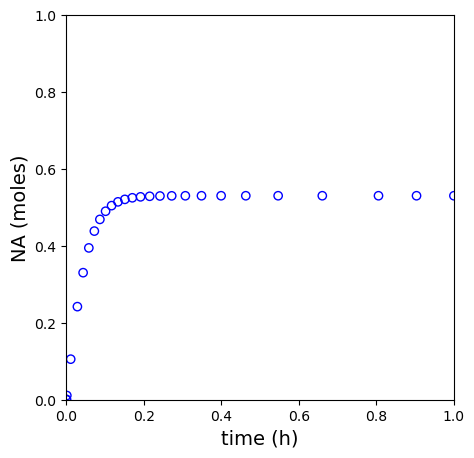

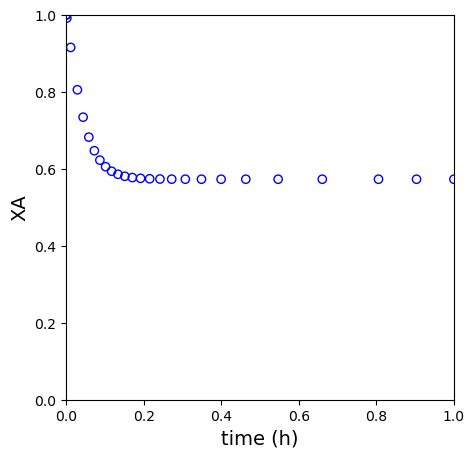

The steady state conversion in this reactor is XA = 0.573


In [5]:
k   = 25.3 #1/h
V   = 1.24 #L
CAf = 1.0 #mol/L
CBf = 1.0 #mol/L
Qf  = 10 #L/h  
FAf = CAf*Qf
FBf = CBf*Qf
N0 = [0.0, 0.0]
tspan = [0, 1]
sol_tCSTR = solve_ivp(P02, tspan, N0, atol = 1e-6, rtol = 1e-6)
tset = sol_tCSTR.t
NA   = sol_tCSTR.y[0,:]
FA   = NA/V*Qf
XA   = (FAf - FA)/FAf

plt.figure(1, figsize = (5, 5))
plt.scatter(tset, NA, color = 'none', edgecolors = 'blue')
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('NA (moles)', fontsize = 14)
plt.show(1)

plt.figure(2, figsize = (5, 5))
plt.scatter(tset, XA, color = 'none', edgecolors = 'blue')
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('XA', fontsize = 14)
plt.show(2)

print(f'The steady state conversion in this reactor is XA = {XA[-1]:0.3f}')

## Writing cleaner code

There is nothing fundamentally wrong with the code in the sections above. It solves the problem correctly.  However, if you study it, you'll see that I defined identical variables in two different places--things like $V$, $C_{Af}$, $C_{Bf}$, etc.  Generally, this is bad practice.  If I want to now consider the impact of a change to that reactor--say an increase or decrease in the feed volumetric flowrate, $Q_f$, I now have to hunt around and make sure that I've redefined $Q_f$ correctly everywhere in my code.

Usually, it is best to define constants only once.  There are various ways you can do this. For example, things that I define in the Python workspace (outside of a function or loop) are global variables by default, which means that, technically, they are accessible inside of a function or loop.  So I could get away with the following alternative code.

In [6]:
%whos

Variable    Type           Data/Info
------------------------------------
CAf         float          1.0
CBf         float          1.0
FA          ndarray        27: 27 elems, type `float64`, 216 bytes
FAf         float          10.0
FBf         float          10.0
N0          list           n=2
NA          ndarray        27: 27 elems, type `float64`, 216 bytes
P01         function       <function P01 at 0x0000029F6125A0E0>
P02         function       <function P02 at 0x0000029F6125A3B0>
Qf          int            10
V           float          1.24
XA          ndarray        27: 27 elems, type `float64`, 216 bytes
XA0         float          0.5
info        RootResults          converged: True\n  <...> root: 0.5727289521699684
k           float          25.3
np          module         <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
opt         module         <module 'scipy.optimize' <...>\\optimize\\__init__.py'>
plt         module         <module 'matplotlib.pyplo<...>\\matplot

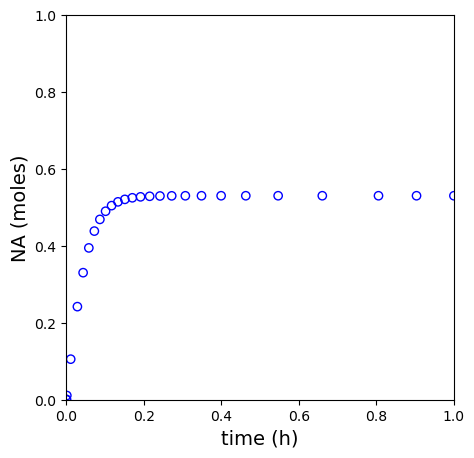

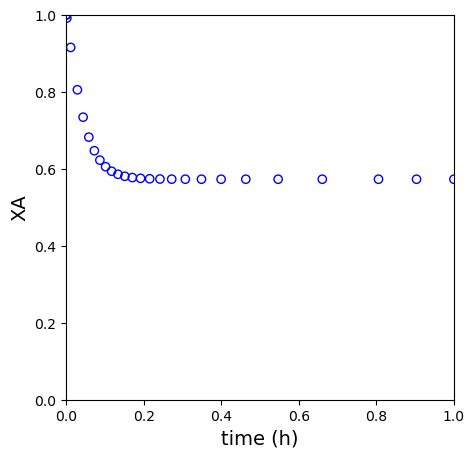

The steady state conversion in this reactor is XA = 0.573


In [7]:
def P02a(t, var): 
    NA  = var[0]
    NB  = var[1]

    FAf = CAf * Qf
    FBf = CBf * Qf

    CA  = NA/V
    CB  = NB/V
    FA  = CA*Qf
    FB  = CB*Qf
    r   = k*CA*CB
    RA  = - r
    RB  = - r
    
    dNAdt = FAf - FA + RA*V
    dNBdt = FBf - FB + RB*V
    return [dNAdt, dNBdt]

N0 = [0.0, 0.0]
tspan = [0, 1]
sol_tCSTRa = solve_ivp(P02a, tspan, N0, atol = 1e-6, rtol = 1e-6)
tset = sol_tCSTR.t
NA   = sol_tCSTR.y[0,:]
FA   = NA/V*Qf
XA   = (FAf - FA)/FAf

plt.figure(1, figsize = (5, 5))
plt.scatter(tset, NA, color = 'none', edgecolors = 'blue')
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('NA (moles)', fontsize = 14)
plt.show(1)

plt.figure(2, figsize = (5, 5))
plt.scatter(tset, XA, color = 'none', edgecolors = 'blue')
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('XA', fontsize = 14)
plt.show(2)

print(f'The steady state conversion in this reactor is XA = {XA[-1]:0.3f}')

### There are risks with relying on global variables this way

In general, the above works, but is not best practice.  There is the risk that I redefine a quantity in the global space, which means I also change the quantities value in the local space inside of the function scope.  I might not intend to do this, so I have to be very careful when using global variables this way.

The tightest, cleanest way to handle this case is to make sure that I'm working with local variable names inside of my function and to pass constants into the function as parameters.  Below, we give an example of how to do this by passing a parameter set to our ODE functionusing the `args` keyword.

In [8]:
def P03(t, N, p): 
    NA, NB = N
    k, V, CAf, CBf, FAf, FBf, Qf = p
    Q = Qf
    
    CA, CB = N/V
    
    FA  = CA*Q
    FB  = CB*Q
    r   = k*CA*CB
    RA  = -r
    RB  = -r
    dNAdt   = FAf - FA + RA*V
    dNBdt   = FBf - FB + RB*V
    return [dNAdt, dNBdt]

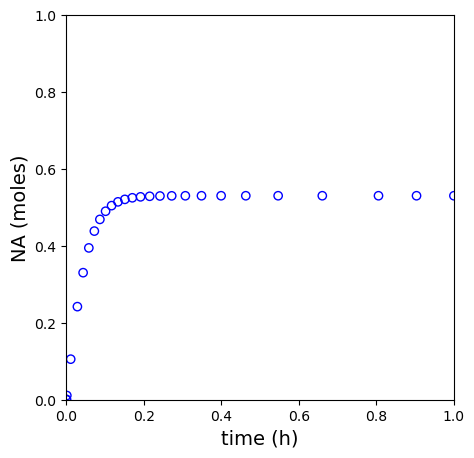

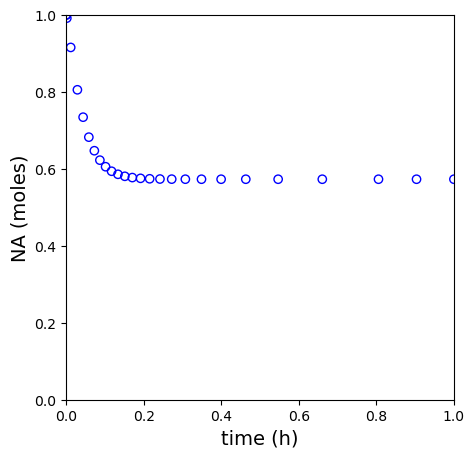

The steady state conversion in this reactor is XA = 0.573


In [9]:
k0   = 25.3 #1/h
V0   = 1.24 #L
CAf0 = 1.0 #mol/L
CBf0 = 1.0 #mol/L
Qf0  = 10 #L/h  
FAf0 = CAf*Qf
FBf0 = CBf*Qf
parameters = [k0, V0, CAf0, CBf0, Qf0, FAf0, FBf0]

N0 = np.array([0.0, 0.0])

#Pass parameters with a lambda function
#odeproblem = lambda t, NA: P03(t, NA, parameters)
#sol_tCSTR = solve_ivp(odeproblem,tspan, NA0, atol = 1e-6, rtol = 1e-6)
#Pass parameters with args keyword
sol_tCSTR = solve_ivp(P03, tspan, N0, args = (parameters, ), atol = 1e-6, rtol = 1e-6)

tset = sol_tCSTR.t
NA   = sol_tCSTR.y[0,:]
CA   = NA/V
FA   = CA*Qf
XA   = (FAf - FA)/FAf

plt.figure(1, figsize = (5, 5))
plt.scatter(tset, NA, color = 'none', edgecolors = 'blue')
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('NA (moles)', fontsize = 14)
plt.show(1)

plt.figure(2, figsize = (5, 5))
plt.scatter(tset, XA, color = 'none', edgecolors = 'blue')
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('NA (moles)', fontsize = 14)
plt.show(2)

print(f'The steady state conversion in this reactor is XA = {XA[-1]:0.3f}')